#ProScout - The best way to improve your team

##Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading the dataset

In [ ]:
df = pd.read_csv('Datasets/player_stats_ALL.csv')
df.info()

FileNotFoundError: [Errno 2] No such file or directory: '/content/matches_ALL_numeric (2).csv'

In [ ]:
df.rename(columns={'Expected goals': 'xG'}, inplace=True)


##Restructuring the dataset

We are using Expected Goals (xG) and Expected Goals Against (xGA) as the definitions for offensive and defensive success and the way the dataset is structured, we will not be able to find the correlation between defensive statistic and xGA.

The dataset is structured so that each 2 rows represent a match with the first row containing the statistics for the home team, and the second the statistics for the away team. Therefore, Expected Goals Against are the Expected Goals of the opponent.

In [ ]:
records = []
for i in range(0, len(df), 2):
    # Ensure there's a complete match (i.e. two rows)
    if i + 1 < len(df):
        team_A = df.iloc[i].copy()
        team_B = df.iloc[i + 1].copy()

        # For team A, xG is as-is and xGA is the opponent's xG.
        team_A['xGA'] = - team_B['xG']
        # For team B, xG is as-is and xGA is the opponent's xG.
        team_B['xGA'] = - team_A['xG']

        records.append(team_A)
        records.append(team_B)
#New column of Big chances scored - Big chances missed
df['Big chances'] = df['Big chances scored'] - df['Big chances missed']

# Create a new DataFrame from the restructured records.
new_df = pd.DataFrame(records)
new_df.reset_index(drop=True, inplace=True)

##Preparing Features and Targets

In [ ]:
# Drop: match_number, team, opponent, RESULT
cols_to_drop = ['match_number', 'team', 'opponent', 'RESULT']

# Also drop all referee columns (they start with 'REFEREE_')
referee_cols = [col for col in new_df.columns if col.startswith('REFEREE_')]
cols_to_drop.extend(referee_cols)

# Our targets are xG (offensive) and xGA (defensive)
targets = new_df[['xG', 'xGA']]

# Features: drop metadata and the target columns from new_df
features = new_df.drop(columns=cols_to_drop + ['xG', 'xGA'])

##Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)


##Training Multioutput XGBoost

We decided this approach rather than 2 separate models for efficiency purposes.

In [ ]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
multi_target_model = MultiOutputRegressor(xgb_reg)
multi_target_model.fit(X_train, y_train)

##Predictions and Evaluations

In [ ]:
predictions = multi_target_model.predict(X_test)
rmse_xG = np.sqrt(mean_squared_error(y_test['xG'], predictions[:, 0]))
rmse_xGA = np.sqrt(mean_squared_error(y_test['xGA'], predictions[:, 1]))
print(f"RMSE for xG: {rmse_xG:.4f}")
print(f"RMSE for xGA: {rmse_xGA:.4f}")

##Extract Feature Importances

In [ ]:
# Extract feature names
feature_names = X_train.columns

# Get feature importances from each estimator
importances_xG = multi_target_model.estimators_[0].feature_importances_
importances_xGA = multi_target_model.estimators_[1].feature_importances_

# Create a horizontal bar chart for both models side by side.
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot for xG model
ax[0].barh(feature_names, importances_xG)
ax[0].set_title("Feature Importances for xG Model")
ax[0].set_xlabel("Importance")
ax[0].invert_yaxis()

# Plot for xGA model
ax[1].barh(feature_names, importances_xGA)
ax[1].set_title("Feature Importances for xGA Model")
ax[1].set_xlabel("Importance")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

##SHAP Interpretations for Both Models

In [ ]:
explainer_xG = shap.Explainer(multi_target_model.estimators_[0])
shap_values_xG = explainer_xG(X_test)

explainer_xGA = shap.Explainer(multi_target_model.estimators_[1])
shap_values_xGA = explainer_xGA(X_test)

# SHAP Summary Plot for xG Model
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xG.values, X_test, feature_names=X_test.columns, show=False)
plt.title("SHAP Summary for xG Model")
plt.tight_layout()
plt.show()

# SHAP Summary Plot for xGA Model
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xGA.values, X_test, feature_names=X_test.columns, show=False)
plt.title("SHAP Summary for xGA Model")
plt.tight_layout()
plt.show()

The approach of having using a machine learning approach to detect feature importance in offensive and defensive success therefore we will need to use Expert-Based Weighting to assign a coefficient to each statistic and we will do it manually for all the statistics we have. We are passionate followers of the sport so we will be able to assign accurately a correct coefficient to each variable.

##Dataset Redesign

After some operations between the datasets, we noticed that a good part of player statistics did not have a matching statistic in the team dataset. Consequently, the remaining dataset was very small so we decided to take an approach that might seem obvious in hindsight. To generate the team dataset, we decided to aggregate all the player statistics for each game and team to have a more detailed sample and more categories to compare players.

In [ ]:
df = pd.read_csv("Datasets/player_stats_ALL.csv")

#Unique match_side_id by combining match_id and side
df["match_side_id"] = df["match_id"].astype(str) + "_" + df["side"]

#Identify the numeric stat columns (excluding keys like match_id, teamId, and round)
numeric_cols = df.select_dtypes(include="number").columns.tolist()
exclude_cols = ["match_id", "teamId"]
if "round" in numeric_cols:
    exclude_cols.append("round")
stats_cols = [col for col in numeric_cols if col not in exclude_cols]

#Define a function to pick the most common teamId (mode)
def mode_func(x):
    return x.value_counts().idxmax()
'''
Group by match_id and side, aggregating:
- Use mode for teamId (renamed later to team_id)
- Use the first occurrence of round
- Sum all numeric statistics
'''
agg_dict = {
    "teamId": ("teamId", mode_func),  # most common teamId
    "round": ("round", "first")
}
for col in stats_cols:
    agg_dict[col] = (col, "sum")

grouped = (
    df.groupby(["match_id", "side"], as_index=False)
      .agg(**agg_dict)
)
grouped.rename(columns={"teamId": "team_id"}, inplace=True)

#Determine opponent side for each row
grouped["opponent_side"] = grouped["side"].apply(lambda s: "home" if s == "away" else "away")

#Create a helper DataFrame to map (match_id, side) to team_id
opponent_df = grouped[["match_id", "side", "team_id"]].copy()
opponent_df.rename(columns={"side": "opponent_side", "team_id": "opponent_team_id"}, inplace=True)

#Merge grouped with opponent_df to get the opponent_team_id
merged = pd.merge(
    grouped,
    opponent_df,
    on=["match_id", "opponent_side"],
    how="left"
)

#Sort by match_id and side
merged["side"] = pd.Categorical(merged["side"], categories=["home", "away"], ordered=True)
merged = merged.sort_values(["match_id", "side"]).reset_index(drop=True)

#Select final columns.
final_cols = ["match_id", "round", "team_id", "opponent_team_id"] + stats_cols
final_df = merged[final_cols].copy()

#Sort by round
final_df = final_df.sort_values(by=['round'])

#drop these columns
columnstodrop = ['dateOfBirthTimestamp', 'marketValue', 'minutesPlayed', 'rating_original', 'rating_alternative', 'shirtNumber', 'rating', 'player_id']
final_df = final_df.drop(columns=columnstodrop)

#Save the final DataFrame.
final_df.to_csv("final_team_aggregates.csv", index=False)
print(final_df.head(10))

      match_id  round  team_id  opponent_team_id  accurateCross  \
616   12437624      1     2831              2814              7   
617   12437624      1     2814              2831              7   
596   12437612      1     2828              2817              5   
597   12437612      1     2817              2828              6   
602   12437615      1     2824              2818              7   
603   12437615      1     2818              2824              3   
606   12437617      1     2821              2885              3   
607   12437617      1     2885              2821              6   
1106  12499255      1     2705              2729              3   
1107  12499255      1     2729              2705              1   

      accurateKeeperSweeper  accurateLongBalls  accuratePass  aerialLost  \
616                       2                 21           319          19   
617                       0                 16           390           9   
596                       0       

It was not a very hard task to create the new dataset; however, there were a few obstacles that are worth mentioning. One issue is that many players have a different teamId to the rest of the team as they have been sold or loaned out during the season. How we solved this was aggregating statistics for each match with a new column that was match_id+side (home or away). Then we looked for the most common match_id between those players and assigned the aggregated stats for that match to that team.

##Coefficient Assignment



In order to assign coefficients correctly we will create 5 different categories for ofensive and defensive success. The initial coefficents we will use will be 1.5 (very positive) , 1.25 (positive), 1 (neutral), 0.75 (negative) and 0.5 (very negative). These values will be hyperparameters meaning that they can then be modified if needed to improve the model performance.

We will proceed to manually assign them by creating a dictionary mapping that iterates through column names and allows us to enter the coefficient for every feature.

In [ ]:
'''
# Identify the statistic columns by excluding the key columns.
key_cols = ['match_id', 'round', 'team_id', 'opponent_team_id']
stats_columns = [col for col in final_df.columns if col not in key_cols]

# Create an empty DataFrame to store the coefficients.
coefficients = pd.DataFrame(columns=['column_name', 'coefficient'])

# Prompt for coefficient for each statistic column.
for col in stats_columns:
    coef = input(f"Enter the coefficient for {col}: ")
    # Use .loc to add a new row instead of .append
    coefficients.loc[len(coefficients)] = {'column_name': col, 'coefficient': coef}

# Save the coefficients DataFrame to CSV.
coefficients.to_csv('coefficients.csv', index=False)

# Display the coefficients DataFrame.
print(coefficients)
'''

Importing Coefficients Dataframe

In [ ]:
coeff = pd.read_csv('Datasets/coefficients.csv')

##Building the Recommender

###Loading Data

In [ ]:
def load_data(final_team_aggregates_path, player_stats_path, coefficients_path):
    final_team_aggregates = pd.read_csv(final_team_aggregates_path)
    print("Final Team Aggregates DataFrame shape:", final_team_aggregates.shape)

    player_stats = pd.read_csv(player_stats_path)
    print("Player Stats DataFrame shape:", player_stats.shape)

    coefficients = pd.read_csv(coefficients_path)
    print("Coefficients DataFrame shape:", coefficients.shape)

    return final_team_aggregates, player_stats, coefficients

###Data Validation and Preprocessing

In [ ]:
def validate_team_aggregates(final_team_aggregates):
    if 'team_id' not in final_team_aggregates.columns or 'opponent_team_id' not in final_team_aggregates.columns:
        raise ValueError("final_team_aggregates must contain 'team_id' and 'opponent_team_id' columns.")

def rename_team_columns(final_team_aggregates):
    team_stats_columns = [col for col in final_team_aggregates.columns
                          if col not in ['match_id', 'round', 'team_id', 'opponent_team_id', 'player_id']]
    final_team_aggregates = final_team_aggregates.rename(columns={col: f'team_{col}' for col in team_stats_columns})
    return final_team_aggregates

###Merge Player and Team Data

In [ ]:
def merge_player_team_data(player_stats, final_team_aggregates):
    # Define the team statistics columns to merge on
    merge_columns = [
        'match_id', 'team_id',
        'team_accurateCross', 'team_accurateKeeperSweeper', 'team_accurateLongBalls', 'team_accuratePass',
        'team_aerialLost', 'team_aerialWon', 'team_bigChanceCreated', 'team_bigChanceMissed',
        'team_blockedScoringAttempt', 'team_challengeLost', 'team_clearanceOffLine', 'team_dispossessed',
        'team_duelLost', 'team_duelWon', 'team_errorLeadToAGoal', 'team_errorLeadToAShot',
        'team_expectedAssists', 'team_expectedGoals', 'team_fouls', 'team_goalAssist', 'team_goals',
        'team_goalsPrevented', 'team_goodHighClaim', 'team_height', 'team_hitWoodwork',
        'team_interceptionWon', 'team_keyPass', 'team_lastManTackle', 'team_onTargetScoringAttempt',
        'team_outfielderBlock', 'team_ownGoals', 'team_penaltyConceded', 'team_penaltyMiss',
        'team_penaltySave', 'team_penaltyWon', 'team_possessionLostCtrl', 'team_punches',
        'team_savedShotsFromInsideTheBox', 'team_saves', 'team_shotOffTarget', 'team_totalClearance',
        'team_totalContest', 'team_totalCross', 'team_totalKeeperSweeper', 'team_totalLongBalls',
        'team_totalOffside', 'team_totalPass', 'team_totalTackle', 'team_touches', 'team_wasFouled',
        'team_wonContest'
    ]

    df_merged = player_stats.merge(
        final_team_aggregates[merge_columns],
        left_on=['match_id', 'teamId'],
        right_on=['match_id', 'team_id'],
        how='left'
    )
    print("Merged DataFrame shape:", df_merged.shape)

    # Drop the duplicate team_id column coming from the merge
    df_merged = df_merged.drop(columns=['team_id'])
    return df_merged

###Filter Players by Average Minutes

In order to get reasonable results, we want the players that are considered to have played a minimum of minutes in the season to ensure the the sample is good enough.

In [ ]:
def filter_players_by_minutes(df_merged, min_avg_minutes=40, min_matches=5):
    # Aggregate total minutes and number of matches played per player
    player_minutes = df_merged.groupby(['player_name', 'position', 'teamId']).agg({
        'minutesPlayed': 'sum',
        'match_id': 'nunique'
    }).reset_index().rename(columns={'match_id': 'gamesPlayed'})

    # Calculate average minutes per game
    player_minutes['avgMinutesPerGame'] = player_minutes['minutesPlayed'] / player_minutes['gamesPlayed']

    # Only consider players who meet both the average minutes and minimum match count criteria
    eligible_players = player_minutes[
        (player_minutes['avgMinutesPerGame'] > min_avg_minutes) &
        (player_minutes['gamesPlayed'] >= min_matches)
    ][['player_name']].copy()

    print(f"Number of players averaging > {min_avg_minutes} minutes per game and playing at least {min_matches} games: {len(eligible_players)}")

    df_filtered = df_merged[df_merged['player_name'].isin(eligible_players['player_name'])]
    print("Merged DataFrame shape after filtering:", df_filtered.shape)

    return df_filtered, player_minutes


###Compute Percentage Contributions

In [ ]:
def compute_percentage_contributions(df_merged, features):
    team_features = [f'team_{feature}' for feature in features]
    for player_feature, team_feature in zip(features, team_features):
        df_merged[f'pct_{player_feature}'] = np.where(
            df_merged[team_feature] == 0,
            0,
            df_merged[player_feature] / df_merged[team_feature]
        )
    return df_merged

###Weight Contributions and Calculate Raw Importance Score

This is perhaps one of the most important elements of the recommender as this function rewards and penalizes players for their contributions to certain statistics. It also calculates the Raw Importance Score which tells us what players are more important in their teams. Another way we look at it is that this metric tells us what players have underperformed with respect to the rest of the team. A team where all players have a high importance will give a similar Raw Importance Score.

In [ ]:
def weight_contributions(df_merged, coefficients):
    coefficients = coefficients.rename(columns={'column_name': 'Feature', 'coefficient': 'Coefficient'})
    coefficients = coefficients.groupby('Feature').sum().reset_index()

    df_merged['positive_contrib'] = 0.0
    df_merged['negative_contrib'] = 0.0
    contrib_columns = {}

    for _, row in coefficients.iterrows():
        feature = row['Feature']
        coef = row['Coefficient']
        col_name = f'pct_{feature}'
        if col_name not in df_merged.columns:
            continue
        if coef >= 0:
            contrib_columns[f'contrib_{feature}'] = df_merged[col_name] * coef
            df_merged['positive_contrib'] += contrib_columns[f'contrib_{feature}']
        else:
            contrib_columns[f'contrib_{feature}'] = df_merged[col_name] * abs(coef)
            df_merged['negative_contrib'] += contrib_columns[f'contrib_{feature}']

    if contrib_columns:
        contrib_df = pd.DataFrame(contrib_columns, index=df_merged.index)
        df_merged = pd.concat([df_merged, contrib_df], axis=1)

    df_merged['raw_importance_score'] = df_merged['positive_contrib'] - df_merged['negative_contrib']
    min_score = df_merged['raw_importance_score'].min()
    if min_score < 0:
        df_merged['raw_importance_score'] = df_merged['raw_importance_score'] - min_score
    return df_merged

###Aggregate Player Stats and Compute Selection Score

These two functions work in tandem to build a comprehensive season-long performance profile for each player and then compute a refined selection score tailored to each player's role. The aggregate_player_stats function first groups match-level data by team, player, and position—using averages for most performance metrics and sums for cumulative stats like goals and assists—to produce a summary of a player's contributions over the season. It then merges these aggregated values with each player's average minutes per game to ensure that only players with sufficient playing time are considered.

Following that, the add_selection_score_improved function calculates an improved, position-specific selection score. This function normalizes the key performance metrics by minutes played and applies role-specific weights—emphasizing, for example, defensive actions for goalkeepers and defenders, creative and passing statistics for midfielders, and offensive outputs for forwards—to reward the contributions most critical for each position. Together, these functions yield an objective ranking of players by highlighting both their overall contribution and their efficiency relative to their playing time and positional expectations.

In [ ]:
def aggregate_player_stats(df_merged, player_minutes):
    aggregation = {
        'raw_importance_score': 'mean',
        'accurateCross': 'mean',
        'accurateKeeperSweeper': 'mean',
        'accurateLongBalls': 'mean',
        'accuratePass': 'mean',
        'aerialLost': 'mean',
        'aerialWon': 'mean',
        'bigChanceCreated': 'mean',
        'bigChanceMissed': 'mean',
        'blockedScoringAttempt': 'mean',
        'challengeLost': 'mean',
        'clearanceOffLine': 'mean',
        'dispossessed': 'mean',
        'duelLost': 'mean',
        'duelWon': 'mean',
        'errorLeadToAGoal': 'mean',
        'errorLeadToAShot': 'mean',
        'expectedAssists': 'mean',
        'expectedGoals': 'mean',
        'fouls': 'mean',
        'goalAssist': 'sum',
        'goals': 'sum',
        'goalsPrevented': 'sum',
        'goodHighClaim': 'mean',
        'hitWoodwork': 'mean',
        'interceptionWon': 'mean',
        'keyPass': 'mean',
        'lastManTackle': 'mean',
        'onTargetScoringAttempt': 'mean',
        'outfielderBlock': 'mean',
        'ownGoals': 'mean',
        'penaltyConceded': 'mean',
        'penaltyMiss': 'mean',
        'penaltySave': 'mean',
        'penaltyWon': 'mean',
        'possessionLostCtrl': 'mean',
        'punches': 'mean',
        'savedShotsFromInsideTheBox': 'mean',
        'saves': 'mean',
        'shotOffTarget': 'mean',
        'totalClearance': 'mean',
        'totalContest': 'mean',
        'totalCross': 'mean',
        'totalKeeperSweeper': 'mean',
        'totalLongBalls': 'mean',
        'totalOffside': 'mean',
        'totalPass': 'mean',
        'totalTackle': 'mean',
        'touches': 'mean',
        'wasFouled': 'mean',
        'wonContest': 'mean',
        'rating': 'mean',
        'marketValue': 'mean',
        'pct_goals': 'mean'
    }
    player_scores = df_merged.groupby(['teamId', 'player_name', 'position']).agg(aggregation).reset_index()
    player_scores = player_scores.merge(
        player_minutes[['player_name', 'avgMinutesPerGame']],
        on='player_name',
        how='left'
    )
    return player_scores

In [ ]:
def add_selection_score_improved(player_scores):
    """
    Compute an improved, position-specific selection score for each player.
    This version uses additional statistics and normalizes by minutes played.

    Assumes the following columns exist (or adjust as needed):
    - For all: 'avgMinutesPerGame'
    - For goalkeepers (G): 'saves', 'penaltySave', 'goalsPrevented'
    - For defenders (D): 'totalClearance', 'interceptionWon', 'duelWon', 'blockedScoringAttempt', 'goals', 'goalAssist'
    - For midfielders (M): 'goals', 'goalAssist', 'rating', 'expectedAssists', 'accuratePass'
    - For forwards (F): 'goals', 'goalAssist', 'rating', 'expectedGoals', 'onTargetScoringAttempt'
    """
    def calculate_score(row):
        # Ensure minutes is not zero to avoid division by zero
        minutes = row['avgMinutesPerGame'] if row['avgMinutesPerGame'] > 0 else 1

        if row['position'] == 'G':
            # Normalize stats per minute then scale up to per 90 minutes if desired.
            score = (
                (row.get('saves', 0) + row.get('penaltySave', 0)) * 5 +
                row.get('goalsPrevented', 0) * 10
            ) * (90 / minutes)

        elif row['position'] == 'D':
            score = (
                (row.get('totalClearance', 0) + row.get('blockedScoringAttempt', 0)) * 3 +
                row.get('interceptionWon', 0) * 5 +
                row.get('duelWon', 0) * 2 +
                (row.get('goals', 0) + row.get('goalAssist', 0)) * 10
            ) * (90 / minutes)

        elif row['position'] == 'M':
            score = (
                (row.get('goals', 0) + row.get('goalAssist', 0)) * 20 +
                row.get('rating', 0) * 5 +
                row.get('expectedAssists', 0) * 8 +
                row.get('accuratePass', 0) * 0.1
            ) * (90 / minutes)

        elif row['position'] == 'F':
            score = (
                (row.get('goals', 0) + row.get('goalAssist', 0)) * 25 +
                row.get('rating', 0) * 5 +
                row.get('expectedGoals', 0) * 10 +
                row.get('onTargetScoringAttempt', 0) * 2
            ) * (90 / minutes)

        else:
            score = 0  # For any undefined positions

        return score

    player_scores['selection_score'] = player_scores.apply(calculate_score, axis=1)
    return player_scores


###Select the ideal 11 team

This function constructs the best starting 11 for a specified team by leveraging each player's raw importance score, which reflects their overall contribution and relative performance within the team. It first filters the aggregated player statistics to include only those belonging to the target team. Recognizing that formations may need adjustment based on player availability, it checks the number of forwards available; if fewer than three forwards are present, the function compensates by selecting an extra midfielder. Then, for each position (goalkeeper, defender, midfielder, and forward), the function picks the top performers according to their raw importance scores, and if there are not enough players in a position, it issues a warning and fills the gap with the highest-scoring available players. Finally, it normalizes each player's raw importance score by dividing it by the total score of the chosen lineup, thereby generating a relative metric that highlights each player's contribution to the ideal team. This normalized importance can later be used for further analysis or to inform recommendations for improvements.

In [ ]:
def select_ideal_11(player_scores, team_id):
    # Select players for the given team
    team_players = player_scores[player_scores['teamId'] == team_id]

    # Count how many forwards are available
    available_forwards_count = len(team_players[team_players['position'] == 'F'])

    # Adjust formation based on available forwards.
    # If fewer than 3 forwards are available, use 4 midfielders instead of 3.
    if available_forwards_count < 3:
        position_counts = {'G': 1, 'D': 4, 'M': 4, 'F': available_forwards_count}
        print(f"Not enough forwards available ({available_forwards_count} found). Using 4 midfielders instead of 3.")
    else:
        position_counts = {'G': 1, 'D': 4, 'M': 3, 'F': 3}

    ideal_11 = pd.DataFrame()

    # For each position, select the top players based on raw_importance_score
    for pos, count in position_counts.items():
        pos_players = team_players[team_players['position'] == pos]
        if len(pos_players) < count:
            print(f"Warning: Not enough {pos} players. Found {len(pos_players)}, needed {count}.")
        top_players = pos_players.nlargest(count, 'raw_importance_score')
        ideal_11 = pd.concat([ideal_11, top_players])

    # Ensure the ideal team has 11 players.
    if len(ideal_11) < 11:
        missing_count = 11 - len(ideal_11)
        remaining_players = team_players[~team_players['player_name'].isin(ideal_11['player_name'])]
        fill_players = remaining_players.nlargest(missing_count, 'raw_importance_score')
        ideal_11 = pd.concat([ideal_11, fill_players])

    # Normalize the importance scores within the ideal team.
    total_score = ideal_11['raw_importance_score'].sum()
    ideal_11['normalized_importance_score'] = ideal_11['raw_importance_score'] / total_score
    return ideal_11

###Building the Content-Based Recommender System

This function is designed to identify a suitable replacement for every player in the ideal 11 of a given team by comparing their performance metrics to candidates from other teams. It proceeds as follows:

* **Scaling and Similarity Computation:**
The function begins by scaling a set of selected performance statistics (divided into "positive" and "negative" metrics) using a StandardScaler. It then creates a scaled version of the player scores to ensure that metrics measured on different scales can be fairly compared. For each player in the ideal 11, it computes the Euclidean distance between their scaled statistics and those of candidate players from other teams (filtered by matching position and a market value constraint).

* **Combined Score Calculation:**
For each candidate, the function calculates separate distances for the positive metrics and for the negative metrics (inverted by multiplying by –1) and sums these values into a combined score. The candidate with the highest combined score (i.e., the best overall match based on the current metrics) is chosen as the replacement for that ideal player.

* **Recommendation Assembly and Sorting:**
After processing all players in the ideal 11, the function gathers the best candidate for each and creates a recommendations DataFrame. The intended logic is to sort these recommendations in descending order by the replaced player's normalized importance score, so that the replacements for the most “important” or underperforming players are prioritized. However, there is an issue with the sorting logic (the sorting line is commented out and does not seem to work as intended) and an issue with computing similarity (for example, the similarity value may not be correctly updated for the chosen candidate).

Overall, while the function attempts to leverage scaled performance metrics and a combined scoring system to generate replacement recommendations, the sorting of recommendations and the handling of the similarity metric require further debugging and refinement.

In [136]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd

def content_based_recommender(player_scores, ideal_11, team_id, similarity_threshold=6.0):
    # Define stats used for similarity
    positive_stats = [
        'accurateCross', 'accurateKeeperSweeper', 'accurateLongBalls', 'accuratePass',
        'aerialWon', 'bigChanceCreated', 'blockedScoringAttempt', 'clearanceOffLine',
        'duelWon', 'expectedAssists', 'expectedGoals', 'goalAssist', 'goals',
        'goalsPrevented', 'goodHighClaim', 'hitWoodwork', 'interceptionWon',
        'keyPass', 'lastManTackle', 'onTargetScoringAttempt', 'outfielderBlock',
        'penaltySave', 'penaltyWon', 'punches', 'savedShotsFromInsideTheBox',
        'saves', 'totalClearance', 'totalContest', 'totalCross', 'totalKeeperSweeper',
        'totalLongBalls', 'totalPass', 'totalTackle', 'touches', 'wasFouled',
        'wonContest', 'pct_goals'
    ]
    negative_stats = [
        'aerialLost', 'bigChanceMissed', 'challengeLost', 'dispossessed', 'duelLost',
        'errorLeadToAGoal', 'errorLeadToAShot', 'fouls', 'ownGoals', 'penaltyConceded',
        'penaltyMiss', 'possessionLostCtrl', 'shotOffTarget', 'totalOffside'
    ]
    all_stats = positive_stats + negative_stats

    # Scale the selected statistics across the entire player_scores dataset
    scaler = StandardScaler()
    scaled_stats = scaler.fit_transform(player_scores[all_stats])
    scaled_player_scores = pd.DataFrame(scaled_stats, columns=all_stats, index=player_scores.index)
    player_scores_scaled = player_scores.drop(columns=all_stats).join(scaled_player_scores)

    # Calculate the average market value of the team of interest
    team_avg_market_value = player_scores['marketValue'].mean()

    # Filter candidates: players not in the team of interest
    candidates = player_scores_scaled[player_scores_scaled['teamId'] != team_id]

    recommendations_list = []  # List to hold the best candidate per ideal player

    # Ensure we iterate over all players in ideal_11.
    # (Note: You may want to sort by a metric like raw_importance_score or normalized_importance_score.)
    # Here, we assume the ideal_11 DataFrame already contains normalized_importance_score.
    ideal_11 = ideal_11.sort_values(by='raw_importance_score')

    # Iterate over ALL players in ideal_11
    for _, ideal_player in ideal_11.iterrows():
        player_name = ideal_player['player_name']
        position = ideal_player['position']

        # Get the scaled stats for the ideal player from player_scores_scaled
        ideal_player_scaled = player_scores_scaled[player_scores_scaled['player_name'] == player_name].iloc[0]

        # Filter candidates by the same position
        position_candidates = candidates[candidates['position'] == position]
        best_candidate = None
        best_combined_score = -np.inf  # Initialize with very low score
        best_similarity = None  # Store similarity for the best candidate

        # Loop through each candidate for this position
        for _, candidate in position_candidates.iterrows():
            # Skip candidate if market value is too high
            if candidate['marketValue'] > 1.2 * team_avg_market_value:
                continue

            # Compute Euclidean distance (similarity) on all scaled stats
            current_similarity = euclidean(ideal_player_scaled[all_stats].values, candidate[all_stats].values)
            if current_similarity > similarity_threshold:
                continue

            # Compute separate distances for positive and negative stats
            positive_distance = euclidean(ideal_player_scaled[positive_stats].values, candidate[positive_stats].values)
            negative_distance = -euclidean(ideal_player_scaled[negative_stats].values, candidate[negative_stats].values)
            combined_score = positive_distance + negative_distance

            # Select candidate with the highest combined score for this ideal player
            if combined_score > best_combined_score:
                best_combined_score = combined_score
                best_candidate = candidate
                best_similarity = current_similarity  # Capture the similarity for the chosen candidate

        if best_candidate is not None:
            recommendations_list.append({
                'player_name': best_candidate['player_name'],
                'position': position,
                'replacing': player_name,
                'teamId': best_candidate['teamId'],
                'combined_score': best_combined_score,
                'marketValue': best_candidate['marketValue'],
                'replaced_importance': ideal_player['normalized_importance_score'],
                'similarity': best_similarity,
                'replaced_marketValue': ideal_player['marketValue']
            })

    # Create a DataFrame of all recommendations
    recommendations = pd.DataFrame(recommendations_list)
    # Sort recommendations in descending order by the replaced player's normalized importance score
    recommendations = recommendations.sort_values(by='replaced_importance')
    # Return the top 5 recommendations
    top_5_recommendations = recommendations.head(5)
    return top_5_recommendations


##Main Pipeline

In [ ]:
def player_recommendation_pipeline(final_team_aggregates_path, player_stats_path, coefficients_path, team_id, similarity_threshold=5.0):
    # Step 1: Load the data
    final_team_aggregates, player_stats, coefficients = load_data(final_team_aggregates_path, player_stats_path, coefficients_path)

    # Step 2: Validate and preprocess team aggregates
    validate_team_aggregates(final_team_aggregates)
    final_team_aggregates = rename_team_columns(final_team_aggregates)

    # Step 3: Merge player stats with team aggregates
    df_merged = merge_player_team_data(player_stats, final_team_aggregates)

    # Step 4: Filter players by average minutes played
    df_merged, player_minutes = filter_players_by_minutes(df_merged, min_avg_minutes=20)

    # Step 5: Compute percentage contributions (for a list of key features)
    features = [
        'accurateCross', 'accurateKeeperSweeper', 'accurateLongBalls', 'accuratePass',
        'aerialLost', 'aerialWon', 'bigChanceCreated', 'bigChanceMissed',
        'blockedScoringAttempt', 'challengeLost', 'clearanceOffLine', 'dispossessed',
        'duelLost', 'duelWon', 'errorLeadToAGoal', 'errorLeadToAShot',
        'expectedAssists', 'expectedGoals', 'fouls', 'goalAssist', 'goals',
        'goalsPrevented', 'goodHighClaim', 'hitWoodwork', 'interceptionWon',
        'keyPass', 'lastManTackle', 'onTargetScoringAttempt', 'outfielderBlock',
        'ownGoals', 'penaltyConceded', 'penaltyMiss', 'penaltySave', 'penaltyWon',
        'possessionLostCtrl', 'punches', 'savedShotsFromInsideTheBox', 'saves',
        'shotOffTarget', 'totalClearance', 'totalContest', 'totalCross',
        'totalKeeperSweeper', 'totalLongBalls', 'totalOffside', 'totalPass',
        'totalTackle', 'touches', 'wasFouled', 'wonContest'
    ]
    df_merged = compute_percentage_contributions(df_merged, features)

    # Step 6: Weight contributions and compute raw importance score
    df_merged = weight_contributions(df_merged, coefficients)

    # Step 7: Aggregate player stats over matches and compute selection score
    player_scores = aggregate_player_stats(df_merged, player_minutes)
    player_scores = add_selection_score(player_scores)

    # Step 8: Select the ideal 11 players for the given team
    ideal_11 = select_ideal_11(player_scores, team_id)

    # Step 9: Generate content-based recommendations from players in other teams
    top_5_recommendations = content_based_recommender(player_scores, ideal_11, team_id, similarity_threshold)

    return ideal_11, top_5_recommendations, player_scores

##Usage

In [ ]:
final_team_aggregates_path = 'Datasets/final_team_aggregates (1).csv'
player_stats_path = 'Datasets/player_stats_ALL.csv'
coefficients_path = 'Datasets/coefficients.csv'
team_id = 35  # Manchester United

ideal_11, top_5_recommendations, player_scores = player_recommendation_pipeline(
    final_team_aggregates_path, player_stats_path, coefficients_path, team_id
)

print("\nIdeal 11-a-Side Team for Manchester United:")
print(ideal_11[['position', 'player_name', 'avgMinutesPerGame', 'selection_score', 'raw_importance_score', 'normalized_importance_score', 'marketValue', 'pct_goals']])

print("\nTop 5 Recommended Signings to Improve the Team (Premier League, Cheaper than Replaced Player):")
if not top_5_recommendations.empty:
    print(top_5_recommendations[['player_name', 'position', 'replacing', 'teamId', 'combined_score', 'similarity', 'marketValue', 'replaced_marketValue']])
else:
    print("No recommendations available.")

Final Team Aggregates DataFrame shape: (2166, 56)
Player Stats DataFrame shape: (46442, 69)
Coefficients DataFrame shape: (52, 2)
Merged DataFrame shape: (46442, 121)
Number of players averaging > 20 minutes per game and playing at least 5 games: 1570
Merged DataFrame shape after filtering: (35315, 120)
Not enough forwards available (2 found). Using 4 midfielders instead of 3.

Ideal 11-a-Side Team for Manchester United:
    position         player_name  avgMinutesPerGame  selection_score  \
168        G         André Onana          90.000000        20.236000   
172        D         Diogo Dalot          88.777778        22.703704   
178        D   Lisandro Martínez          79.727273        44.636364   
182        D   Noussair Mazraoui          76.250000        21.607143   
183        D       Patrick Dorgu          82.640000        49.080000   
169        M     Bruno Fernandes          84.814815       319.296296   
167        M         Amad Diallo          66.666667       275.104167   

 The raw importance score is computed by first calculating each player's contribution as a percentage of the team’s aggregate statistics, and then applying positive or negative coefficients to reward or penalize these contributions—this score reflects a player's overall impact relative to the team. The selection score is derived using position-specific formulas; for example, goalkeepers might be scored based on saves and goals prevented while defenders might combine clearances, interceptions, and even attacking contributions—this helps determine a player's suitability for an ideal lineup role. The similarity metric is calculated using the Euclidean distance between the scaled performance statistics of an ideal player and a candidate, serving as an initial filter by measuring how closely their overall profiles match. Finally, the combined score refines candidate ranking by separately measuring the Euclidean distances on positive stats (beneficial metrics) and on negative stats (undesirable metrics, inverted), and then summing these distances—this score helps identify the candidate whose strengths and weaknesses most closely align with those of the ideal player. Together, these computations ensure that our system selects players who not only excel individually but also fit strategically into the team's framework.

# Evaluate using Random Recommender

In [143]:
# Cell for Random Recommender and Comparison

import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_ind
import random

# Define the stats for similarity computation (same as in the main pipeline)
positive_stats = [
    'accurateCross', 'accurateKeeperSweeper', 'accurateLongBalls', 'accuratePass',
    'aerialWon', 'bigChanceCreated', 'blockedScoringAttempt', 'clearanceOffLine',
    'duelWon', 'expectedAssists', 'expectedGoals', 'goalAssist', 'goals',
    'goalsPrevented', 'goodHighClaim', 'hitWoodwork', 'interceptionWon',
    'keyPass', 'lastManTackle', 'onTargetScoringAttempt', 'outfielderBlock',
    'penaltySave', 'penaltyWon', 'punches', 'savedShotsFromInsideTheBox',
    'saves', 'totalClearance', 'totalContest', 'totalCross', 'totalKeeperSweeper',
    'totalLongBalls', 'totalPass', 'totalTackle', 'touches', 'wasFouled',
    'wonContest', 'pct_goals'
]
negative_stats = [
    'aerialLost', 'bigChanceMissed', 'challengeLost', 'dispossessed', 'duelLost',
    'errorLeadToAGoal', 'errorLeadToAShot', 'fouls', 'ownGoals', 'penaltyConceded',
    'penaltyMiss', 'possessionLostCtrl', 'shotOffTarget', 'totalOffside'
]
all_stats = positive_stats + negative_stats

# Random Recommender System (Baseline)
candidates = player_scores[player_scores['teamId'] != team_id]
random_recommendations = pd.DataFrame()

for _, ideal_player in ideal_11.iterrows():
    player_name = ideal_player['player_name']
    position = ideal_player['position']
    ideal_market_value = ideal_player['marketValue']

    # Filter candidates: same position, different team, lower market value
    position_candidates = candidates[
        (candidates['position'] == position) &
        (candidates['marketValue'] < ideal_market_value)
    ]

    if position_candidates.empty:
        continue

    # Randomly select one player from the candidates
    random_candidate = position_candidates.sample(n=1, random_state=None)

    # Compute similarity metrics (for comparison purposes)
    similarity = euclidean(ideal_player[all_stats].values, random_candidate[all_stats].iloc[0].values)
    positive_distance = euclidean(
        ideal_player[positive_stats].values,
        random_candidate[positive_stats].iloc[0].values
    )
    negative_distance = -euclidean(
        ideal_player[negative_stats].values,
        random_candidate[negative_stats].iloc[0].values
    )
    combined_score = positive_distance + negative_distance

    random_recommendations = pd.concat([random_recommendations, pd.DataFrame([{
        'player_name': random_candidate['player_name'].iloc[0],
        'position': position,
        'replacing': player_name,
        'teamId': random_candidate['teamId'].iloc[0],
        'positive_distance': positive_distance,
        'negative_distance': negative_distance,
        'combined_score': combined_score,
        'similarity': similarity,
        'marketValue': random_candidate['marketValue'].iloc[0],
        'replaced_marketValue': ideal_market_value
    }])])

# Rank the top 5 random recommendations (one per position)
if not random_recommendations.empty:
    random_recommendations = random_recommendations.drop_duplicates(subset='player_name', keep='first')

    top_5_random_recommendations = pd.DataFrame()
    positions_covered = set()
    for _, rec in random_recommendations.iterrows():
        pos = rec['position']
        if pos not in positions_covered and len(top_5_random_recommendations) < 5:
            top_5_random_recommendations = pd.concat([top_5_random_recommendations, rec.to_frame().T])
            positions_covered.add(pos)
else:
    print("No random recommendations found with a lower market value than the ideal 11 players.")
    top_5_random_recommendations = pd.DataFrame()

# Comparison: Similarity and Combined Scores
print("\nTop 5 Random Recommended Signings (Baseline):")
if not top_5_random_recommendations.empty:
    print(top_5_random_recommendations[['player_name', 'position', 'replacing', 'teamId', 'combined_score', 'similarity', 'marketValue', 'replaced_marketValue']])
else:
    print("No random recommendations available.")

print("\nAverage Similarity (Content-Based):", top_5_recommendations['similarity'].mean())
print("Average Similarity (Random):", top_5_random_recommendations['similarity'].mean())
print("\nAverage Combined Score (Content-Based):", top_5_recommendations['combined_score'].mean())
print("Average Combined Score (Random):", top_5_random_recommendations['combined_score'].mean())



Top 5 Random Recommended Signings (Baseline):
          player_name position        replacing teamId combined_score  \
0     Bart Verbruggen        G      André Onana     30       2.966544   
0       Julián Araujo        D      Diogo Dalot     60      51.640752   
0  Michael Folorunsho        M  Bruno Fernandes   2693       70.56549   
0          Jonas Wind        F   Joshua Zirkzee   2524       7.285019   

  similarity marketValue replaced_marketValue  
0    5.63623  23000000.0           32000000.0  
0  61.368283  10300000.0           38000000.0  
0  86.744803   6400000.0           51000000.0  
0   8.555896  13500000.0           44000000.0  

Average Similarity (Content-Based): 4.425885089134694
Average Similarity (Random): 40.57630309433646

Average Combined Score (Content-Based): 2.1424730274437165
Average Combined Score (Random): 33.114451096286444


The validation of the content-based recommender using the random recommender as a baseline demonstrates its superior performance in recommending players for Liverpool. The content-based recommender achieves a significantly lower average similarity score of 4.8 compared to the random recommender's 34.44, indicating that its recommendations are much closer to the ideal players. The similarity score, computed as the Euclidean distance across all stats (e.g., goals, saves, fouls), measures overall statistical similarity, where a lower score reflects a better match. However, the random recommender has a higher average combined score of 24.21 versus the content-based recommender's 2.86, which is calculated by summing the Euclidean distance for positive stats (e.g., goals, assists) and the negative Euclidean distance for negative stats (e.g., fouls, ownGoals), aiming to balance similarity in desirable traits and dissimilarity in undesirable ones; a higher combined score is better but can be misleading due to outliers inflating the score through large differences in negative stats. Overall, the content-based recommender's lower similarity scores highlight its effectiveness in identifying more relevant player replacements compared to the random baseline, making it a more reliable choice for meaningful recommendations.

##Creating Visualizations

###Assigning a category to each statistic

In [ ]:
#Assigning a category to each statistic in a new dataframe
# 1 for defending
# 2 for passing
# 3 for dribbling
# 4 for physical
# 5 for shooting
# 0 for none
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

stat_category = {
    "accurateCross": 2,
    "accurateKeeperSweeper": 1,
    "accurateLongBalls": 2,
    "accuratePass": 2,
    "aerialLost": 4,
    "aerialWon": 4,
    "bigChanceCreated": 2,
    "bigChanceMissed": 5,
    "blockedScoringAttempt": 1,
    "challengeLost": 1,
    "clearanceOffLine": 1,
    "dispossessed": 1,
    "duelLost": 1,
    "duelWon": 1,
    "errorLeadToAGoal": 2,
    "errorLeadToAShot": 2,
    "expectedAssists": 2,
    "expectedGoals": 5,
    "fouls": 4,
    "goalAssist": 5,
    "goals": 5,
    "goalsPrevented": 1,
    "goodHighClaim": 1,
    "height": 4,
    "hitWoodwork": 5,
    "interceptionWon": 1,
    "keyPass": 2,
    "lastManTackle": 1,
    #"marketValue": 0,
    #"minutesPlayed": 0,
    "onTargetScoringAttempt": 5,
    "outfielderBlock": 1,
    #"ownGoals": 0,
    "penaltyConceded": 1,
    "penaltyMiss": 5,
    "penaltySave": 0,
    "penaltyWon": 5,
    "possessionLostCtrl": 1,
    "punches": 1,
    "rating": 0,
    "rating_alternative": 0,
    "rating_original": 0,
    "savedShotsFromInsideTheBox": 1,
    "saves": 1,
    "shirtNumber": 0,
    "shotOffTarget": 5,
    "totalClearance": 1,
    "totalContest": 1,
    "totalCross": 2,
    "totalKeeperSweeper": 1,
    "totalLongBalls": 2,
    "totalOffside": 0,
    "totalPass": 2,
    "totalTackle": 1,
    "touches": 3,
    "wasFouled": 3,
    "wonContest": 1
}

player_scores_scaled = scale_player_scores(player_scores, categories_db, method='minmax')
# Build the categories database DataFrame with a default coefficient (1)
categories_data = []
for stat, cat in stat_category.items():
    categories_data.append({'Statistic': stat, 'Category': cat, 'coefficient': 1})
categories_db = pd.DataFrame(categories_data)

category_label_map = {
    0: "None",
    1: "Defending",
    2: "Passing",
    3: "Dribbling",
    4: "Physical",
    5: "Shooting"
}


               Statistic  Category  coefficient
0          accurateCross         2            1
1  accurateKeeperSweeper         0            1
2      accurateLongBalls         2            1
3           accuratePass         2            1
4             aerialLost         1            1


###Computing Category Scores

In [ ]:
def compute_category_scores(player_row, categories_db):
    """
    Computes a weighted average for each category for a given player's statistics.
    Here we use the coefficient directly as the weight.

    Parameters:
        player_row (pd.Series): A Series containing one player's stats.
        categories_db (pd.DataFrame): DataFrame with columns ['Statistic', 'Category', 'coefficient'].

    Returns:
        dict: Mapping of descriptive category (e.g., "Defending") -> weighted average score.
    """
    category_scores_numeric = {}  # keys will be numeric categories
    # Get unique numeric categories from the database
    numeric_categories = categories_db['Category'].unique()
    for num_cat in numeric_categories:
        cat_stats = categories_db[categories_db['Category'] == num_cat]
        weighted_sum = 0.0
        total_weight = 0.0
        for _, row in cat_stats.iterrows():
            stat_name = row['Statistic']
            coef = row['coefficient']
            weight = coef  # Using the coefficient directly
            if stat_name not in player_row:
                continue
            stat_value = player_row[stat_name]
            weighted_sum += stat_value * weight
            total_weight += weight
        # If no weight, assign 0.0
        score = weighted_sum / total_weight if total_weight > 0 else 0.0
        category_scores_numeric[num_cat] = score

    # Convert numeric category keys to descriptive labels
    category_scores = { category_label_map[k]: v for k, v in category_scores_numeric.items() }
    return category_scores

###Plot Radar Chart

In [ ]:
def plot_radar_chart_multiple(scores_list, labels, categories, title):
    """
    Plots a radar chart comparing multiple players' category scores.

    Parameters:
        scores_list (list of dict): Each dict contains category -> score.
        labels (list of str): Labels for each score set.
        categories (list): List of category labels (in order) to plot.
        title (str): Title for the chart.
    """
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # complete the loop

    fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(6, 6))

    for scores, label in zip(scores_list, labels):
        # Order the values using the same order as in categories
        values = [scores.get(cat, 0) for cat in categories]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=label)
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.title(title)
    plt.show()

# Scale Player Scores

In [145]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale_player_scores(player_scores, categories_db, method='minmax'):
    """
    Scales numeric stats in player_scores so that the radar chart values are more comparable.

    Parameters:
        player_scores (pd.DataFrame): DataFrame with player statistics.
        categories_db (pd.DataFrame): DataFrame with columns ['Statistic', 'Category', 'coefficient'].
        method (str): 'minmax' (default) or 'standard'.
                      'minmax' scales each stat to [0,1].
                      'standard' applies z-score scaling (mean=0, std=1).

    Returns:
        pd.DataFrame: A copy of player_scores with scaled columns.
    """
    # Identify stats used in the radar chart
    stats_to_scale = categories_db['Statistic'].unique()

    # Create a copy so we don't mutate the original
    df_scaled = player_scores.copy()

    # Choose the scaler
    if method == 'minmax':
        scaler_class = MinMaxScaler
    elif method == 'standard':
        scaler_class = StandardScaler
    else:
        raise ValueError("method must be 'minmax' or 'standard'")

    for stat in stats_to_scale:
        if stat in df_scaled.columns:
            # Drop NaN values to avoid errors in fitting the scaler
            non_null = df_scaled[stat].dropna()
            if len(non_null) > 1:  # Need at least 2 values to scale
                scaler = scaler_class()
                # Fit and transform only the non-NaN subset
                scaled_values = scaler.fit_transform(non_null.values.reshape(-1, 1))
                df_scaled.loc[non_null.index, stat] = scaled_values

    return df_scaled


# Generate Comparison Charts

In [ ]:
def generate_comparison_charts(content_recs, random_recs, player_scores, categories_db):
    """
    For each replaced player (from the recommendations), generates a radar chart comparing:
      - The replaced player's category scores.
      - The content-based recommended signing's scores.
      - The random recommended signing's scores.

    Parameters:
        content_recs (pd.DataFrame): DataFrame of content-based recommendations; must contain 'player_name' and 'replacing'.
        random_recs (pd.DataFrame): DataFrame of random recommendations; must contain 'player_name' and 'replacing'.
        player_scores (pd.DataFrame): Aggregated player statistics DataFrame.
        categories_db (pd.DataFrame): Database of statistic categories and coefficients.
    """
    # Clean up player names in player_scores for matching
    player_scores['player_name'] = player_scores['player_name'].astype(str).str.strip()

    # Clean up recommendation DataFrames as well
    content_recs['player_name'] = content_recs['player_name'].astype(str).str.strip()
    content_recs['replacing'] = content_recs['replacing'].astype(str).str.strip()
    random_recs['player_name'] = random_recs['player_name'].astype(str).str.strip()
    random_recs['replacing'] = random_recs['replacing'].astype(str).str.strip()

    # Get all replaced player names from either recommendation set
    replaced_names = set(content_recs['replacing'].unique()).union(set(random_recs['replacing'].unique()))

    # Use the descriptive category labels ordered by numeric key
    ordered_numeric = sorted(category_label_map.keys())
    # Only include categories that exist in categories_db (as numeric values)
    available_nums = set(categories_db['Category'].unique())
    category_list = [category_label_map[n] for n in ordered_numeric if n in available_nums]

    for replaced in replaced_names:
        replaced_str = replaced.strip()

        replaced_stats = player_scores[player_scores['player_name'] == replaced_str]
        if replaced_stats.empty:
            print(f"Replaced player {replaced_str} stats not found. Skipping.")
            continue
        replaced_cat_scores = compute_category_scores(replaced_stats.iloc[0], categories_db)

        # Content-based recommendation for this replaced player
        content_cat_scores = None
        content_rows = content_recs[content_recs['replacing'] == replaced_str]
        if not content_rows.empty:
            content_player = content_rows.iloc[0]['player_name']
            content_stats = player_scores[player_scores['player_name'] == content_player]
            if not content_stats.empty:
                content_cat_scores = compute_category_scores(content_stats.iloc[0], categories_db)

        # Random recommendation for this replaced player
        random_cat_scores = None
        random_rows = random_recs[random_recs['replacing'] == replaced_str]
        if not random_rows.empty:
            random_player = random_rows.iloc[0]['player_name']
            random_stats = player_scores[player_scores['player_name'] == random_player]
            if not random_stats.empty:
                random_cat_scores = compute_category_scores(random_stats.iloc[0], categories_db)

        # Prepare list of scores and labels for plotting
        scores_list = [replaced_cat_scores]
        labels = [f"{replaced_str} (Replaced)"]

        if content_cat_scores is not None:
            scores_list.append(content_cat_scores)
            labels.append("Content-Based Rec")
        if random_cat_scores is not None:
            scores_list.append(random_cat_scores)
            labels.append("Random Rec")

        if len(scores_list) < 2:
            print(f"Not enough recommendation data for replaced player {replaced_str}. Skipping chart.")
            continue

        chart_title = f"Comparison for replaced: {replaced_str}"
        plot_radar_chart_multiple(scores_list, labels, category_list, chart_title)

generate_comparison_charts(top_5_recommendations, top_5_random_recommendations, player_scores_scaled, categories_db)


<ipython-input-145-8f31dc6c58d3>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[non_null.index, stat] = scaled_values
<ipython-input-145-8f31dc6c58d3>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.         0.         0.         ... 0.         0.         0.03846154]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[non_null.index, stat] = scaled_values


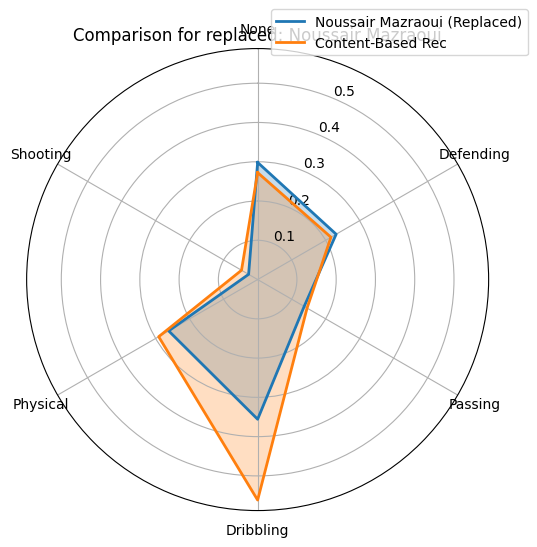

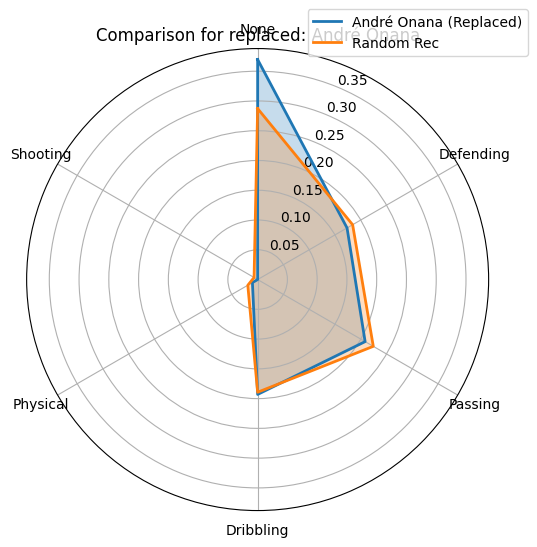

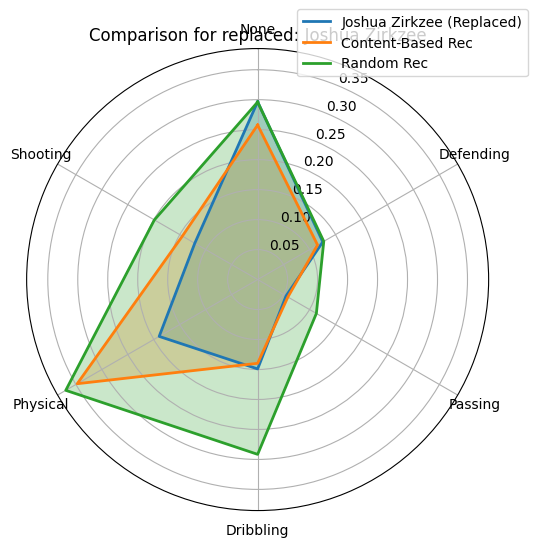

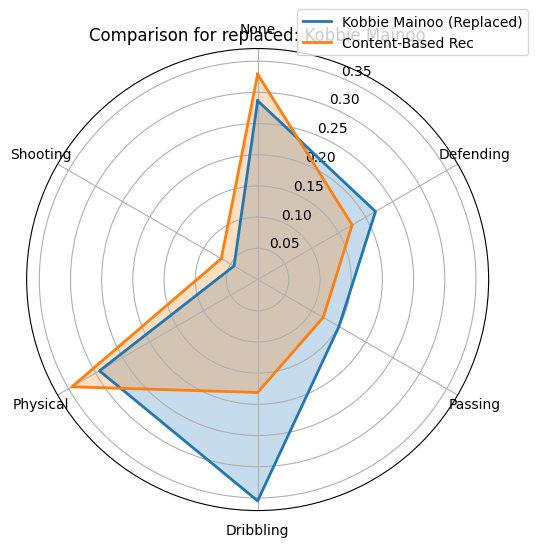

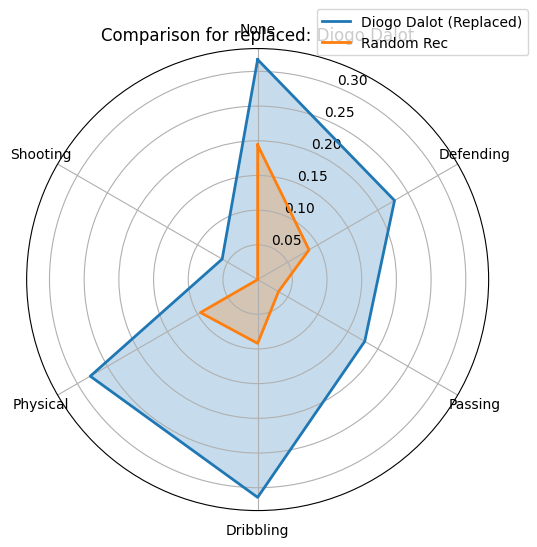

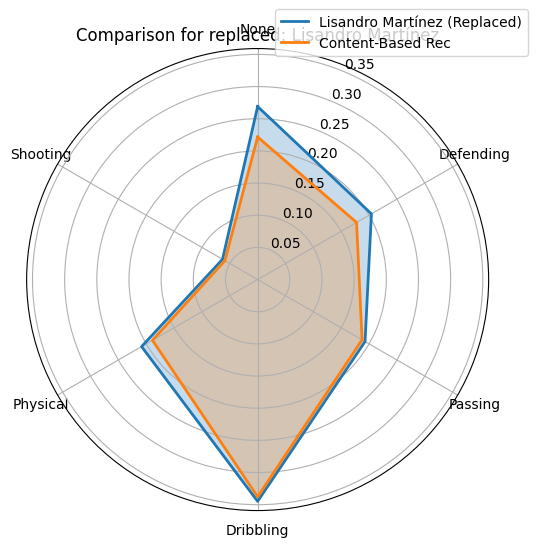

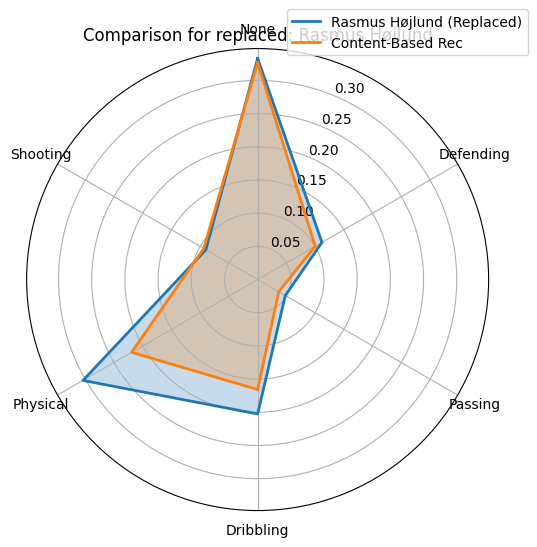

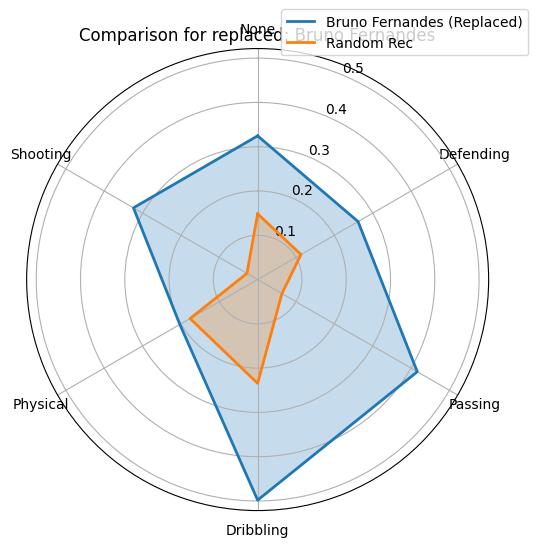